# 0.0 Configurações iniciais

## 0.1 Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sweetviz as sv
import xgboost as xgb
import pickle

import inflection
import warnings
import random

from matplotlib import pyplot as plt

from IPython.display import Image
from IPython.core.display import HTML

from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder, StandardScaler

from sklearn import model_selection as ms
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model as lm
from sklearn import metrics as mt

import scikitplot as skplt

warnings.filterwarnings('ignore')

## 0.2 Funções auxiliares

In [2]:
def jupyter_settings():
    %matplotlib inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [24, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:75% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

# def standardization(x):
#     if isinstance(x, (int, float, np.number)):
#         return (x - df4['annual_premium'].mean()) / df4['annual_premium'].std()
#     else:
#         return x
    
# def minmaxscaler_age(x):
#     if isinstance(x, (int, float, np.number)):
#         return (x - df4['age'].min()) / (df4['age'].max() - df4['age'].min())
#     else:
#         return x
    
# def minmaxscaler_vintage(x):
#     if isinstance(x, (int, float, np.number)):
#         return (x - df4['vintage'].min()) / (df4['vintage'].max() - df4['vintage'].min())
#     else:
#         return x

def precision_top_k(data, k = 2000, target = 'response'):
    
    data = data.reset_index(drop = True)
    
    data['ranking'] = data.index + 1
    
    # cumsum = soma acumulada até posição 'k'
    data['precision_at_k'] = data[target].cumsum()/data['ranking']
    
    return data.loc[k, 'precision_at_k']

def recall_top_k(data, k = 2000, target = 'response'):
    
    data = data.reset_index(drop = True)
    
    data['ranking'] = data.index + 1
    
    # cumsum = soma acumulada até a posição 'k'
    data['recall_at_k'] = data[target].cumsum()/data[target].sum()
    
    return data.loc[k, 'recall_at_k']

def cross_validation(x_train, y_train, x_val, y_val, kfold, model, verbose = False):
    
    # colunas selecionadas (>2% de importância):
    cols_selected_mdi = ['vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage', 'policy_sales_channel', 'previously_insured']

    # juntando treino e validação após preparados os dados
    df_train = x_train.copy()
    df_train['response'] = y_train.copy()
    df_val = x_val.copy()
    df_val['response'] = y_val.copy()
    df_model = pd.concat([df_train, df_val])
    
    # listas de precision e recall contendo cada iteração do cross-validation
    precision_top_k_list = []
    recall_top_k_list = []
    
    for k in range(1, kfold+1):
        if verbose:
            print('\nKFold Number: {}'.format(k))
            
        # modelagem
        x = df_model.drop(['response'], axis = 1)
        y = df_model['response']
        
        # separação em treino e validação
        x_train, x_val, y_train, y_val = ms.train_test_split(x, y, test_size = 0.2) # retirar o random_state para pegar valores diferentes em cada iteração
        
        # seleção de colunas para o treino
        x_train_select = x_train[cols_selected_mdi]
        x_val_select = x_val[cols_selected_mdi]
            
        # treino
        m = model.fit(x_train_select, y_train)

        # predição
        yhat_val = m.predict_proba(x_val_select)
        
        # performance
        df_test = x_val.copy()
        df_test['response'] = y_val.copy()
        
        # propensão de compra
        df_test['score'] = yhat_val[:,1].tolist()

        # ordenação
        df_test = df_test.sort_values(by = 'score', ascending = False)

        # performance
        precision_at_k = precision_top_k(df_test)
        recall_at_k = recall_top_k(df_test)
        
        # performance para cada interação (kfold)
        precision_top_k_list.append(precision_at_k)
        recall_top_k_list.append(recall_at_k)
        
        print(f'Precision Top K: {np.round(precision_at_k, 4)}, Recall Top K: {np.round(recall_at_k, 4)}')    
    
    print(f'\nPrecisão Top K Média: {np.average(precision_top_k_list)}, Recall Top K Média: {np.average(recall_top_k_list)}\n')

    return df_test

# 1.0 Coleta dos dados

## 1.1 Leitura dos dados

In [3]:
df1 = pd.read_csv('data/train.csv')

## 1.2 Visão geral dos dados

In [4]:
print('Os nomes das colunas são: \n{}\n'.format(df1.columns))
print('As colunas e os tipos do conjunto de dados são: \n{}\n'.format(df1.dtypes))
print('O tamanho do conjunto de dados é (linhas, colunas): \n{}\n'.format(df1.shape))
print('A quantidade de linhas vazias para cada coluna é: \n{}\n'.format(df1.isna().sum()))

Os nomes das colunas são: 
Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

As colunas e os tipos do conjunto de dados são: 
id                        int64
Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

O tamanho do conjunto de dados é (linhas, colunas): 
(381109, 12)

A quantidade de linhas vazias para cada coluna é: 
id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Veh

In [5]:
df1.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


# 2.0 Descrição dos dados

## 2.1 Renomeando colunas

In [6]:
df2 = df1.copy()

cols_old = ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response']

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))
df2.columns = cols_new

print('Os nomes das colunas são: \n{}\n'.format(df2.columns))

Os nomes das colunas são: 
Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')



## 2.2 Alterando tipos dos dados

In [7]:
# alterando dados float64 para diminuir o tamanho do dataset
df2['region_code'] = df2['region_code'].astype('int64')
df2['policy_sales_channel'] = df2['policy_sales_channel'].astype('int64')
df2['annual_premium'] = df2['annual_premium'].astype('float32')

# transformando atributos categóricos em numéricos
df2['gender'] = df2['gender'].apply(lambda x: 0 if x == 'Female' else 1)
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 0 if x == 'No' else 1)
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 1 if (x == '< 1 Year') else 
                                                      2 if (x == '1-2 Year') else 
                                                      3 if (x == '> 2 Years') else x)

print('As colunas e os tipos do conjunto de dados são: \n{}\n'.format(df2.dtypes))

As colunas e os tipos do conjunto de dados são: 
id                        int64
gender                    int64
age                       int64
driving_license           int64
region_code               int64
previously_insured        int64
vehicle_age               int64
vehicle_damage            int64
annual_premium          float32
policy_sales_channel      int64
vintage                   int64
response                  int64
dtype: object



## 2.3 Estatística descritiva

In [8]:
# atributos numéricos
num_attributes = df2.select_dtypes(include=['int64', 'float32'])

# atributos categóricos
cat_attributes = df2.select_dtypes(exclude=['int64', 'float32'])

# dropando id
num_attributes = num_attributes.drop(['id'], axis = 1)

# tendência central - mean, meadina 
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersão - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T 
d2 = pd.DataFrame(num_attributes.apply(min)).T 
d3 = pd.DataFrame(num_attributes.apply(max)).T 
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T 
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T 
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T 

# concatenar
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,gender,0.0,1.0,1.0,0.540761,1.0,0.498336,-0.163590,-1.973249
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,0.672539,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-21.595182,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-0.115266,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,0.167747,-1.971871
5,vehicle_age,1.0,3.0,2.0,1.609616,2.0,0.567439,0.252896,-0.792253
6,vehicle_damage,0.0,1.0,1.0,0.504877,1.0,0.499976,-0.019507,-1.999630
7,annual_premium,2630.0,540165.0,537535.0,30577.921875,31669.0,17207.476562,1.766088,34.004574
8,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-0.900008,-0.970810
9,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,0.003030,-1.200688


# 3.0 Análise exploratória dos dados

## 3.1 Análise univariada

In [9]:
df3 = df2.copy()

# tabela para melhor visualização de atributos com menos valores distintos
count_distinct = df3.drop(['id'], axis = 1)

for i in count_distinct.columns:
    count_distinct = df3[i].value_counts()
    count_distinct = pd.DataFrame({i: count_distinct.index, 'count': count_distinct.values})
    print('{}\n'.format(count_distinct.head()))
    # gender = 0 -> female

   gender   count
0       1  206089
1       0  175020

   age  count
0   24  25960
1   23  24256
2   22  20964
3   25  20636
4   21  16457

   driving_license   count
0                1  380297
1                0     812

   region_code   count
0           28  106415
1            8   33877
2           46   19749
3           41   18263
4           15   13308

   previously_insured   count
0                   0  206481
1                   1  174628

   vehicle_age   count
0            2  200316
1            1  164786
2            3   16007

   vehicle_damage   count
0               1  192413
1               0  188696

   annual_premium  count
0          2630.0  64877
1         69856.0    140
2         39008.0     41
3         38287.0     38
4         45179.0     38

   policy_sales_channel   count
0                   152  134784
1                    26   79700
2                   124   73995
3                   160   21779
4                   156   10661

   vintage  count
0      256   1

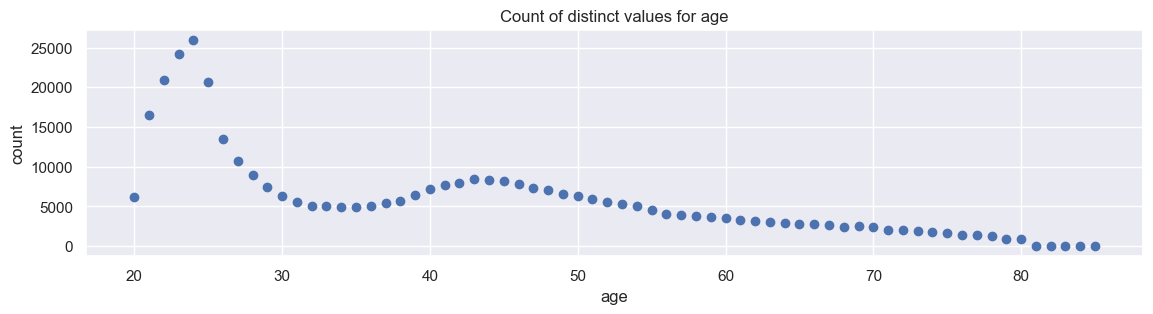

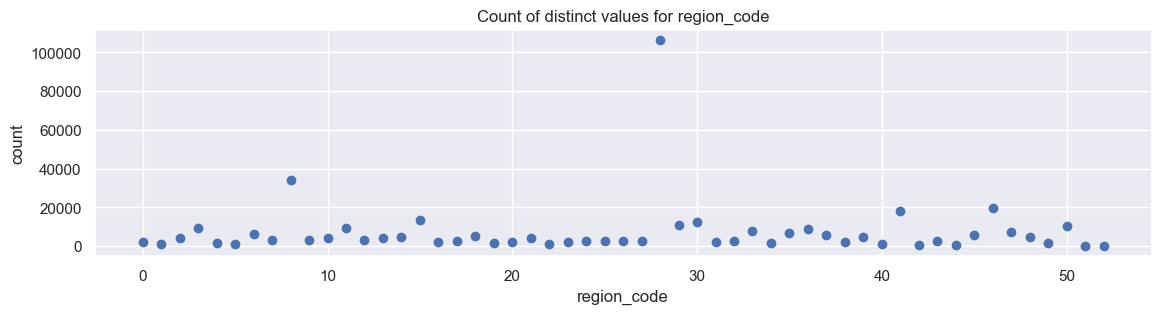

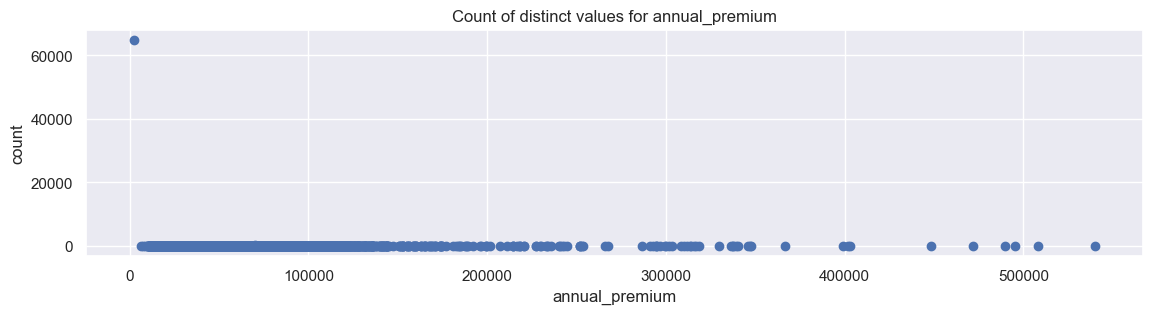

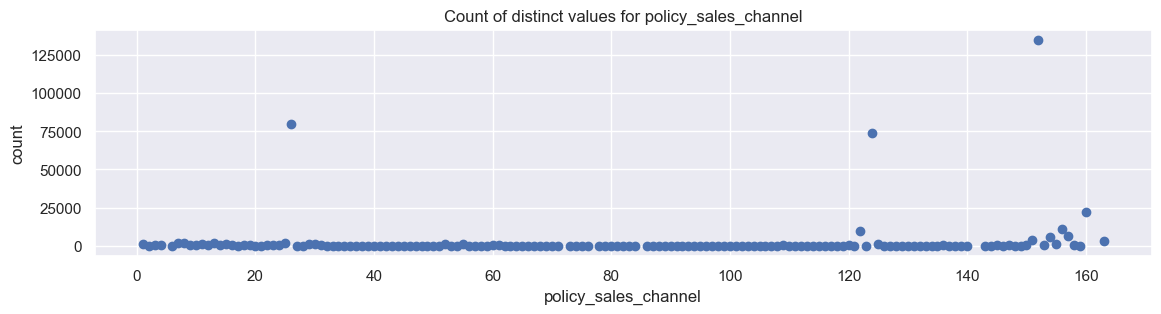

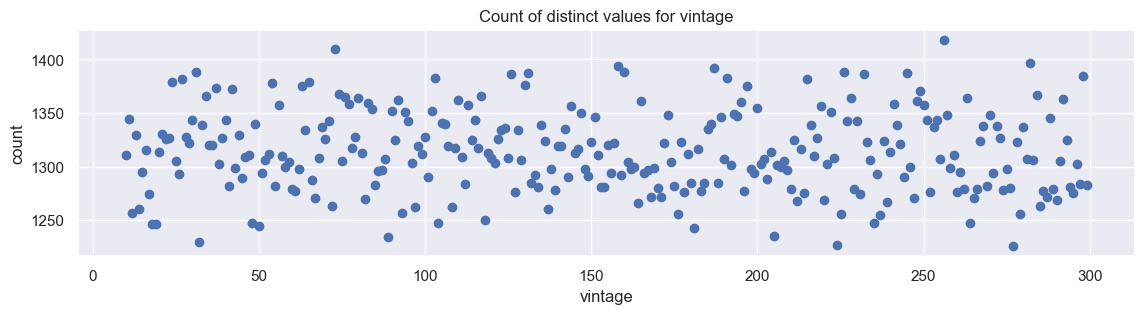

In [10]:
# plot para melhor visualização de atributos com mais valores distintos
count_distinct = df3[['age', 'region_code', 'annual_premium', 'policy_sales_channel', 'vintage']]

for i in count_distinct.columns:
    count_distinct = df3[i].value_counts()
    count_distinct = pd.DataFrame({i: count_distinct.index, 'count': count_distinct.values})
    plt.figure(figsize=(30, 10))
    plt.subplot(3, 2, 1)
    plt.scatter(x = count_distinct.iloc[:,0], y = count_distinct.iloc[:,1])
    plt.title('Count of distinct values for {}'.format(i))
    plt.xlabel(i)
    plt.ylabel('count')
    plt.show()

## 3.2 Análise bivariada - Contagem

In [11]:
# tabela para melhor visualização de atributos com menos valores distintos - contagem
dist_resp = df3.drop(['id', 'response'], axis = 1)

for i in dist_resp.columns:
    dist_resp = pd.crosstab(df3[i], df3['response'])
    # o parâmetro 'normalize' que normaliza as colunas proporcionalmente de acordo com a contagens de linhas = 0 e de linhas = 1
    print(f'A coluna {i} tem a seguinte contagem de interesse: \n{dist_resp.head()}\n')
    # gender = 0 -> female

A coluna gender tem a seguinte contagem de interesse: 
response       0      1
gender                 
0         156835  18185
1         177564  28525

A coluna age tem a seguinte contagem de interesse: 
response      0    1
age                 
20         6061  171
21        15883  574
22        20201  763
23        23364  892
24        25047  913

A coluna driving_license tem a seguinte contagem de interesse: 
response              0      1
driving_license               
0                   771     41
1                333628  46669

A coluna region_code tem a seguinte contagem de interesse: 
response        0     1
region_code            
0            1847   174
1             899   109
2            3751   287
3            8070  1181
4            1516   285

A coluna previously_insured tem a seguinte contagem de interesse: 
response                 0      1
previously_insured               
0                   159929  46552
1                   174470    158

A coluna vehicle_age tem a

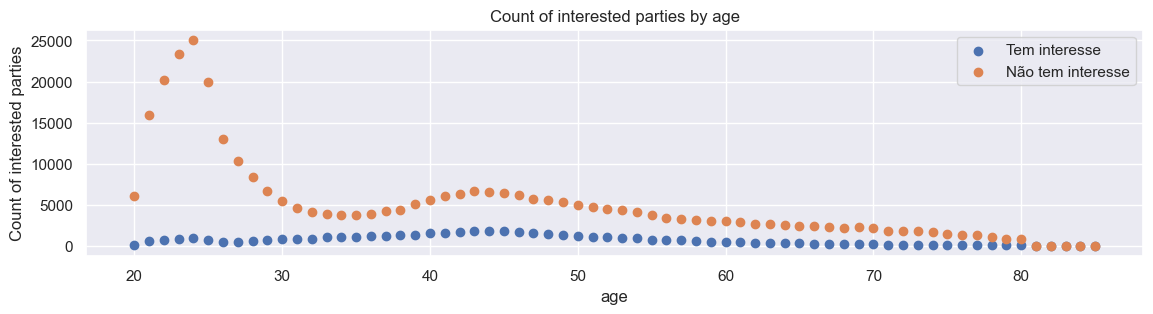

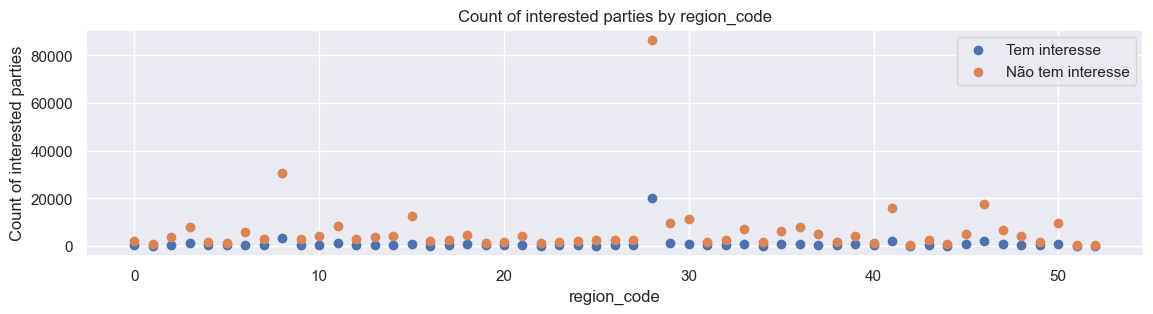

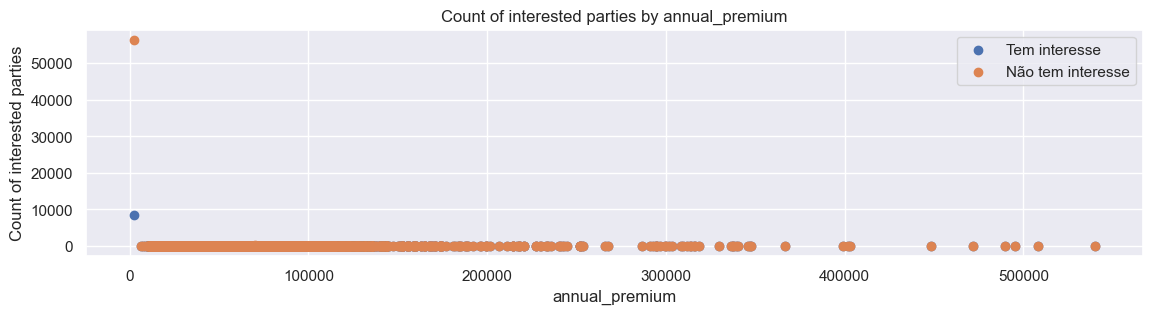

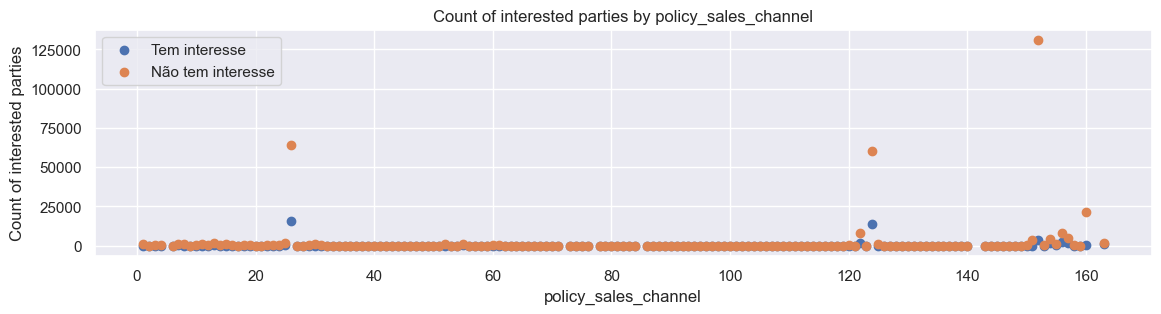

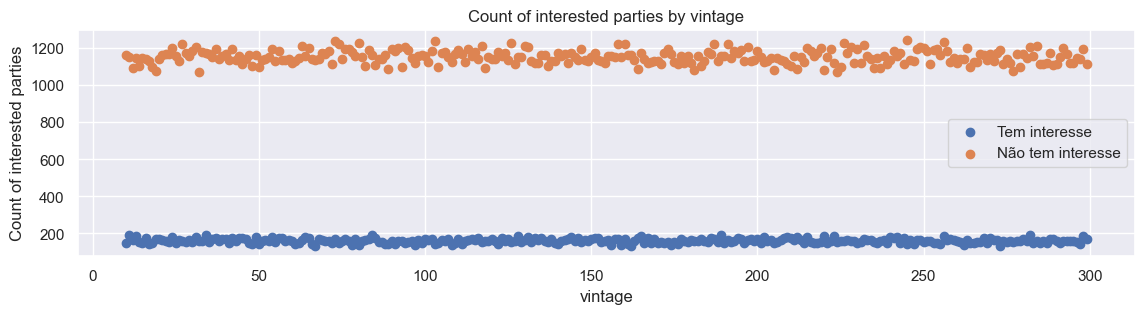

In [12]:
# plot para melhor visualização de atributos com mais valores distintos - contagem
dist_resp = df3[['age', 'region_code', 'annual_premium', 'policy_sales_channel', 'vintage']]

for i in dist_resp.columns:
    dist_resp = pd.crosstab(df3[i], df3['response'])
    dist_resp = dist_resp.reset_index()
    plt.figure(figsize=(30, 10))
    plt.subplot(3, 2, 1)
    plt.scatter(x = dist_resp.iloc[:,0], y = dist_resp.iloc[:,2], label = 'Tem interesse')
    plt.scatter(x = dist_resp.iloc[:,0], y = dist_resp.iloc[:,1], label = 'Não tem interesse')
    plt.title('Count of interested parties by {}'.format(i))
    plt.xlabel(i)
    plt.ylabel('Count of interested parties')
    plt.legend()
    plt.show()

## 3.3 Análise bivariada - Proporção de interesse

In [13]:
# tabela para melhor visualização de atributos com menos valores distintos - proporção de interesse
dist_resp = df3.drop(['id', 'response'], axis = 1)

for i in dist_resp.columns:
    dist_resp = pd.crosstab(df3[i], df3['response'], normalize = 'index')
    # o parâmetro 'normalize' que normaliza as colunas proporcionalmente de acordo com a contagens de linhas = 0 e de linhas = 1
    print(f'A coluna {i} tem a seguinte proporção de interesse: \n{dist_resp.head()}\n')
    # gender = 0 -> female

A coluna gender tem a seguinte proporção de interesse: 
response         0         1
gender                      
0         0.896098  0.103902
1         0.861589  0.138411

A coluna age tem a seguinte proporção de interesse: 
response         0         1
age                         
20        0.972561  0.027439
21        0.965121  0.034879
22        0.963604  0.036396
23        0.963226  0.036774
24        0.964831  0.035169

A coluna driving_license tem a seguinte proporção de interesse: 
response                0         1
driving_license                    
0                0.949507  0.050493
1                0.877283  0.122717

A coluna region_code tem a seguinte proporção de interesse: 
response            0         1
region_code                    
0            0.913904  0.086096
1            0.891865  0.108135
2            0.928925  0.071075
3            0.872338  0.127662
4            0.841755  0.158245

A coluna previously_insured tem a seguinte proporção de interesse: 
respon

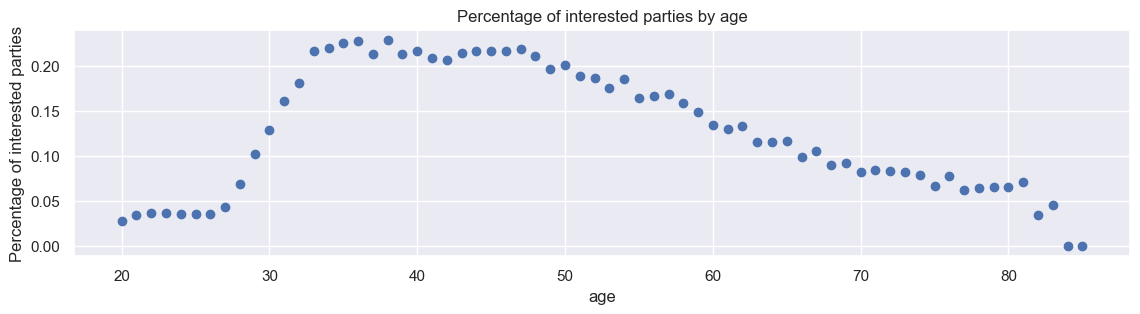

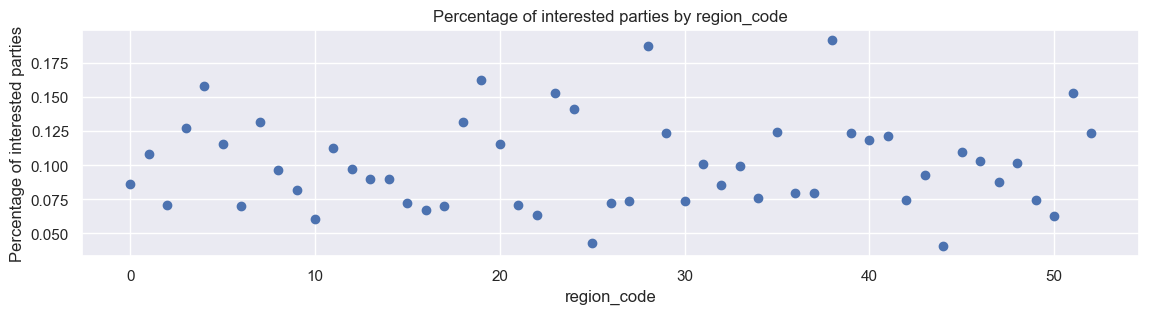

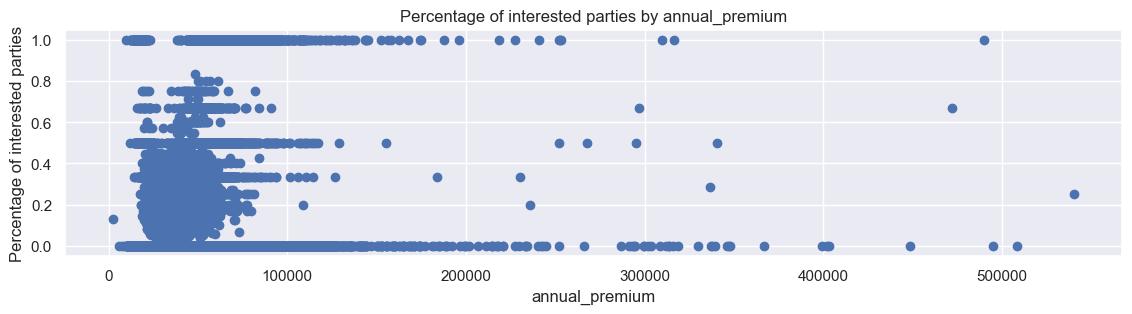

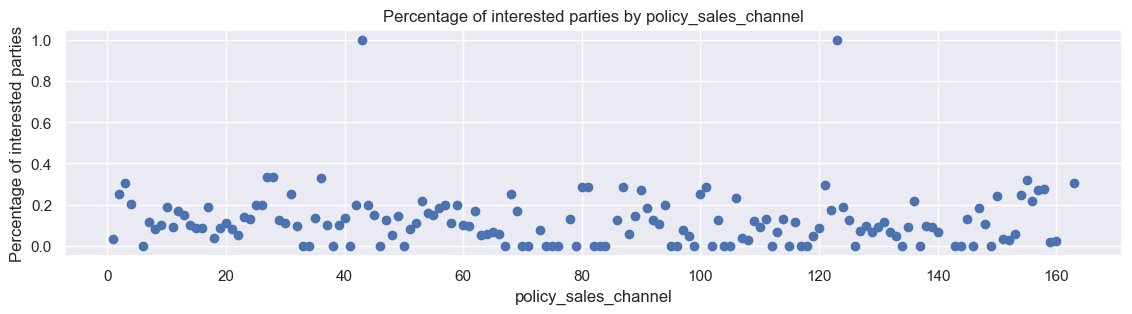

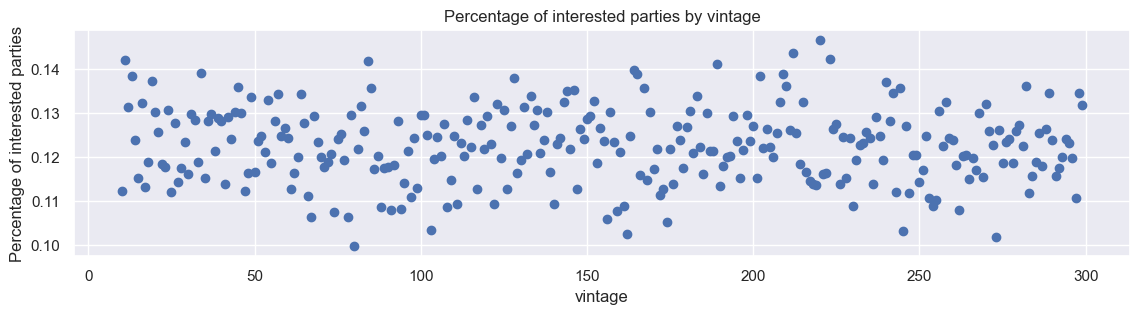

In [14]:
# plot para melhor visualização de atributos com mais valores distintos - porcentagem de interessados
dist_resp = df3[['age', 'region_code', 'annual_premium', 'policy_sales_channel', 'vintage']]

for i in dist_resp.columns:
    dist_resp = pd.crosstab(df3[i], df3['response'], normalize = 'index')
    dist_resp = dist_resp.reset_index()
    plt.figure(figsize=(30, 10))
    plt.subplot(3, 2, 1)
    plt.scatter(x = dist_resp.iloc[:,0], y = dist_resp.iloc[:,2])
    plt.title('Percentage of interested parties by {}'.format(i))
    plt.xlabel(i)
    plt.ylabel('Percentage of interested parties')
    plt.show()

## 3.4 Relatório com o SweetViz

In [15]:
# report = sv.analyze(source = df3, target_feat = 'response')
# report.show_html()

In [16]:
df3.to_csv('data/df3.csv', index = False)

# 4.0 Preparação dos dados

## 4.1 Separação em treino e validação

In [17]:
# lê os dados gravados para não precisar carregar toda a limpeza dos dados e análise exploratória
df41 = pd.read_csv('data/df3.csv')
df41.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,1,44,1,28,0,3,1,40454.0,26,217,1
1,2,1,76,1,3,0,2,0,33536.0,26,183,0
2,3,1,47,1,28,0,3,1,38294.0,26,27,1
3,4,1,21,1,11,1,1,0,28619.0,152,203,0
4,5,0,29,1,41,1,1,0,27496.0,152,39,0


In [18]:
# separação entre features e label
x = df41.drop(['response'], axis = 1)
y = df41['response']

# precisa separar antes para que os dados de validação não vejam as transformações que serão feitas nos dados de treino
x_train, x_val, y_train, y_val = ms.train_test_split(x, y, test_size = 0.2, random_state = 42)

df4 = pd.concat([x_train, y_train], axis = 1)
df4.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
332803,332804,0,39,1,15,0,2,1,52906.0,55,227,1
116248,116249,1,38,1,11,0,2,1,23038.0,26,29,0
255005,255006,1,22,1,30,1,1,0,45318.0,152,166,0
317474,317475,0,23,1,41,1,1,0,29132.0,151,277,0
344212,344213,1,56,1,48,0,3,1,2630.0,154,155,0


## 4.2 Normalização

In [19]:
# ss = StandardScaler()
# df4['annual_premium'] = ss.fit_transform(df4[['annual_premium']].values)

# df4.head()

In [20]:
# annual_premium
df4['annual_premium'] = (df4['annual_premium'] - df4['annual_premium'].mean()) / df4['annual_premium'].std()

df4.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
332803,332804,0,39,1,15,0,2,1,1.294415,55,227,1
116248,116249,1,38,1,11,0,2,1,-0.436638,26,29,0
255005,255006,1,22,1,30,1,1,0,0.854639,152,166,0
317474,317475,0,23,1,41,1,1,0,-0.083449,151,277,0
344212,344213,1,56,1,48,0,3,1,-1.619419,154,155,0


## 4.3 Reescala

In [21]:
# mms_age = MinMaxScaler()
# mms_vintage = MinMaxScaler()
# df4['age'] = mms_age.fit_transform(df4[['age']].values)
# df4['vintage'] = mms_vintage.fit_transform(df4[['vintage']].values)

# df4.head()

In [22]:
# age and vintage
df4['age'] = (df4['age'] - df4['age'].min()) / (df4['age'].max() - df4['age'].min())
df4['vintage'] = (df4['vintage'] - df4['vintage'].min()) / (df4['vintage'].max() - df4['vintage'].min())

df4.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
332803,332804,0,0.292308,1,15,0,2,1,1.294415,55,0.750865,1
116248,116249,1,0.276923,1,11,0,2,1,-0.436638,26,0.065744,0
255005,255006,1,0.030769,1,30,1,1,0,0.854639,152,0.539792,0
317474,317475,0,0.046154,1,41,1,1,0,-0.083449,151,0.923875,0
344212,344213,1,0.553846,1,48,0,3,1,-1.619419,154,0.501730,0


## 4.4 Encoding

In [23]:
# region_code - target encoder
rc_encoder = df4.groupby('region_code')['response'].mean()
df4.loc[:,'region_code'] = df4['region_code'].map(rc_encoder)

# policy_sales_channel - frequency encoder
psc_encoder = df4.groupby('policy_sales_channel').size()/len(df4)
df4.loc[:,'policy_sales_channel'] = df4['policy_sales_channel'].map(psc_encoder)

df4.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
332803,332804,0,0.292308,1,0.070151,0,2,1,1.294415,0.003309,0.750865,1
116248,116249,1,0.276923,1,0.109796,0,2,1,-0.436638,0.209638,0.065744,0
255005,255006,1,0.030769,1,0.074305,1,1,0,0.854639,0.353472,0.539792,0
317474,317475,0,0.046154,1,0.122946,1,1,0,-0.083449,0.010050,0.923875,0
344212,344213,1,0.553846,1,0.100978,0,3,1,-1.619419,0.015901,0.501730,0


## 4.5 Preparação dos dados de validação

In [24]:
x_val['annual_premium'] = (x_val['annual_premium'] - x_val['annual_premium'].mean()) / x_val['annual_premium'].std()

x_val['age'] = (x_val['age'] - x_val['age'].min()) / (x_val['age'].max() - x_val['age'].min())

x_val['vintage'] = (x_val['vintage'] - x_val['vintage'].min()) / (x_val['vintage'].max() - x_val['vintage'].min())

x_val.loc[:,'region_code'] = x_val['region_code'].map(rc_encoder)

x_val.loc[:,'policy_sales_channel'] = x_val['policy_sales_channel'].map(psc_encoder)

# para caso algum 'policy_sales_channel' ou 'region_code' não aparça na validação, preencher com 0
x_val = x_val.fillna(0)

# 5.0 Seleção de atributos

## 5.1 Seleção por importância

In [25]:
# Separação entre features e label
x_train_select = df4.drop(['id', 'response'], axis = 1).values
y_train_select = y_train.values

# Treinando um modelo de random forest para selecionar as features
model_select = RandomForestClassifier(n_estimators = 100, random_state = 42, n_jobs = -1)
model_select.fit(x_train_select, y_train_select)

# Selecionando as features de maior importância através do modelo treinado
n_features = x_train_select.shape[1] # shape[1] -> quantidade de colunas, se fosse shape[0] -> quantidade de linhas
feature_names = [f"feature {i}" for i in range(n_features)]
importances = model_select.feature_importances_
forest_importances = pd.Series(importances, index = feature_names)

row_labels = {'feature 0': 'gender',
              'feature 1': 'age',
              'feature 2': 'driving_license',
              'feature 3': 'region_code',
              'feature 4': 'previously_insured',
              'feature 5': 'vehicle_age',
              'feature 6': 'vehicle_damage',
              'feature 7': 'annual_premium',
              'feature 8': 'policy_sales_channel',
              'feature 9': 'vintage'}

forest_importances.rename(index = row_labels, inplace = True)
df_forest_importances = pd.DataFrame(data = forest_importances).reset_index()
df_forest_importances.rename(columns = {'index': 'Features', 0: 'Relevância Percentual'}).sort_values(by = 'Relevância Percentual', ascending = False)

,Features,Relevância Percentual
9,vintage,0.282478
7,annual_premium,0.252189
1,age,0.146168
3,region_code,0.094896
6,vehicle_damage,0.073483
8,policy_sales_channel,0.070491
4,previously_insured,0.050273
5,vehicle_age,0.016213
0,gender,0.013262
2,driving_license,0.000547


In [26]:
# Colunas selecionadas (>2% de importância):
cols_selected_mdi = ['vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage', 'policy_sales_channel', 'previously_insured']

x_train = df4.copy()

# 6.0 Modelagem

## 6.1 KNN

In [27]:
knn_model = KNeighborsClassifier(n_neighbors = 5)

knn = cross_validation(x_train, y_train, x_val, y_val, 5, knn_model, verbose = False)

Precision Top K: 0.3338, Recall Top K: 0.0703
Precision Top K: 0.3233, Recall Top K: 0.0689
Precision Top K: 0.3203, Recall Top K: 0.0691
Precision Top K: 0.3238, Recall Top K: 0.0694
Precision Top K: 0.3178, Recall Top K: 0.0678

Precisão Top K Média: 0.32383808095952027, Recall Top K Média: 0.06910270440878623



## 6.2 Logistic Regression

In [28]:
# classes balanceadas
lr_model = lm.LogisticRegression(n_jobs = -1, max_iter = 100, class_weight = 'balanced')

lr = cross_validation(x_train, y_train, x_val, y_val, 5, lr_model, verbose = False)

Precision Top K: 0.2989, Recall Top K: 0.0646
Precision Top K: 0.3018, Recall Top K: 0.0653
Precision Top K: 0.3148, Recall Top K: 0.0679
Precision Top K: 0.3043, Recall Top K: 0.0659
Precision Top K: 0.2974, Recall Top K: 0.0636

Precisão Top K Média: 0.30344827586206896, Recall Top K Média: 0.06547922945262671



## 6.3 Random Forest

In [29]:
rf_model = RandomForestClassifier(n_estimators = 100, n_jobs = -1)

rf = cross_validation(x_train, y_train, x_val, y_val, 5, rf_model, verbose = False)

Precision Top K: 0.3698, Recall Top K: 0.0788
Precision Top K: 0.3608, Recall Top K: 0.0775
Precision Top K: 0.3583, Recall Top K: 0.0756
Precision Top K: 0.3628, Recall Top K: 0.0772
Precision Top K: 0.3668, Recall Top K: 0.0782

Precisão Top K Média: 0.36371814092953525, Recall Top K Média: 0.07744433076153011



## 6.4 XGBoost

In [30]:
xgb_model = xgb.XGBClassifier(objective = 'binary:logistic', n_estimators = 100, nthread = -1)

xgb_ = cross_validation(x_train, y_train, x_val, y_val, 5, xgb_model, verbose = False)

Precision Top K: 0.4243, Recall Top K: 0.0907
Precision Top K: 0.4173, Recall Top K: 0.0892
Precision Top K: 0.4213, Recall Top K: 0.09
Precision Top K: 0.4253, Recall Top K: 0.0919
Precision Top K: 0.4233, Recall Top K: 0.0894

Precisão Top K Média: 0.42228885557221385, Recall Top K Média: 0.09022531716733934



# 7.0 Tunagem de hiperparâmetros

## 7.1 Randomized search

In [31]:
# param = {
#    'n_estimators': [100, 300, 500, 1000],
#    'max_depth': [1, 2, 3, 4, 5],
#    'subsample': [0.5, 0.7, 0.8],
#    'colsample_bytree': [0.5, 0.7, 0.8],
#    'scale_pos_weight': [1, 7]
#        }

# max_eval = 30 # irá pegar 30 conjuntos diferentes de parâmetros
# kfold = 5 # irá realizar 5 divisões no dataset para o cross-validation

# for i in range(max_eval):
#     hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
#     print(f'{hp}\n')
   
#     # como a melhor performance obitda foi com o xgb, a tunagem dos parâmetros ocorrerá com ele
#     xgb_tun = xgb.XGBClassifier(objective = 'binary:logistic',
#                                  n_estimators = hp['n_estimators'], 
#                                  max_depth = hp['max_depth'], 
#                                  subsample = hp['subsample'],
#                                  colsample_bytree = hp['colsample_bytree'],
#                                  scale_pos_weight = hp['scale_pos_weight'])
    
#     result = cross_validation(x_train, y_train, x_val, y_val, kfold, xgb_tun, verbose = False)

## 7.2 Generalização

In [32]:
# instanciando o modelo final com os parâmetros tunados
xgb_final = xgb.XGBClassifier(objective = 'binary:logistic',
                              n_estimators = 300,
                              max_depth = 2,
                              subsample = 0.7,
                              colsample_bytree = 0.7,
                              scale_pos_weight = 7,
                              nthread = -1)

# modelo final com o cross-validation
df_final = cross_validation(x_train, y_train, x_val, y_val, 5, xgb_final, verbose = False)

Precision Top K: 0.4478, Recall Top K: 0.0949
Precision Top K: 0.4338, Recall Top K: 0.093
Precision Top K: 0.4243, Recall Top K: 0.0913
Precision Top K: 0.4203, Recall Top K: 0.0891
Precision Top K: 0.4193, Recall Top K: 0.0898

Precisão Top K Média: 0.4290854572713643, Recall Top K Média: 0.09162363039577046



In [33]:
df_final.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response,score
7349,7350,1,0.461538,1,0.186579,0,2,1,4.485514,0.209638,0.629758,1,0.910295
297268,297269,0,0.446154,1,0.186579,0,2,1,4.455376,0.209638,0.712803,1,0.910295
236501,236502,1,0.200000,1,0.109796,0,2,1,-0.403249,0.007734,0.622837,0,0.903708
190782,190783,1,0.384615,1,0.137931,0,2,1,4.428727,0.209638,0.114187,1,0.901465
8725,8726,1,0.215385,1,0.109796,0,2,1,-0.253668,0.007734,0.508651,1,0.898787


# 8.0 Resultados de negócio

## 8.1 Curvas de ganho e lift

In [34]:
df_test = df_final.copy()

# porcentagem de interessados
df_test['real_cum'] = df_test['response'].cumsum() 
df_test['real_cum_perc'] = 100*df_test['real_cum']/df_test['response'].sum()

# porcentagem da base
df_test['base'] = range(1, len(df_test)+1)
df_test['base_cum_perc'] = 100*df_test['base']/len(df_test)

# modelo baseline
df_test['baseline'] = df_test['base_cum_perc']

In [35]:
df_test.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response,score,real_cum,real_cum_perc,base,base_cum_perc,baseline
7349,7350,1,0.461538,1,0.186579,0,2,1,4.485514,0.209638,0.629758,1,0.910295,1,0.010700,1,0.001312,0.001312
297268,297269,0,0.446154,1,0.186579,0,2,1,4.455376,0.209638,0.712803,1,0.910295,2,0.021400,2,0.002624,0.002624
236501,236502,1,0.200000,1,0.109796,0,2,1,-0.403249,0.007734,0.622837,0,0.903708,2,0.021400,3,0.003936,0.003936
190782,190783,1,0.384615,1,0.137931,0,2,1,4.428727,0.209638,0.114187,1,0.901465,3,0.032099,4,0.005248,0.005248
8725,8726,1,0.215385,1,0.109796,0,2,1,-0.253668,0.007734,0.508651,1,0.898787,4,0.042799,5,0.006560,0.006560


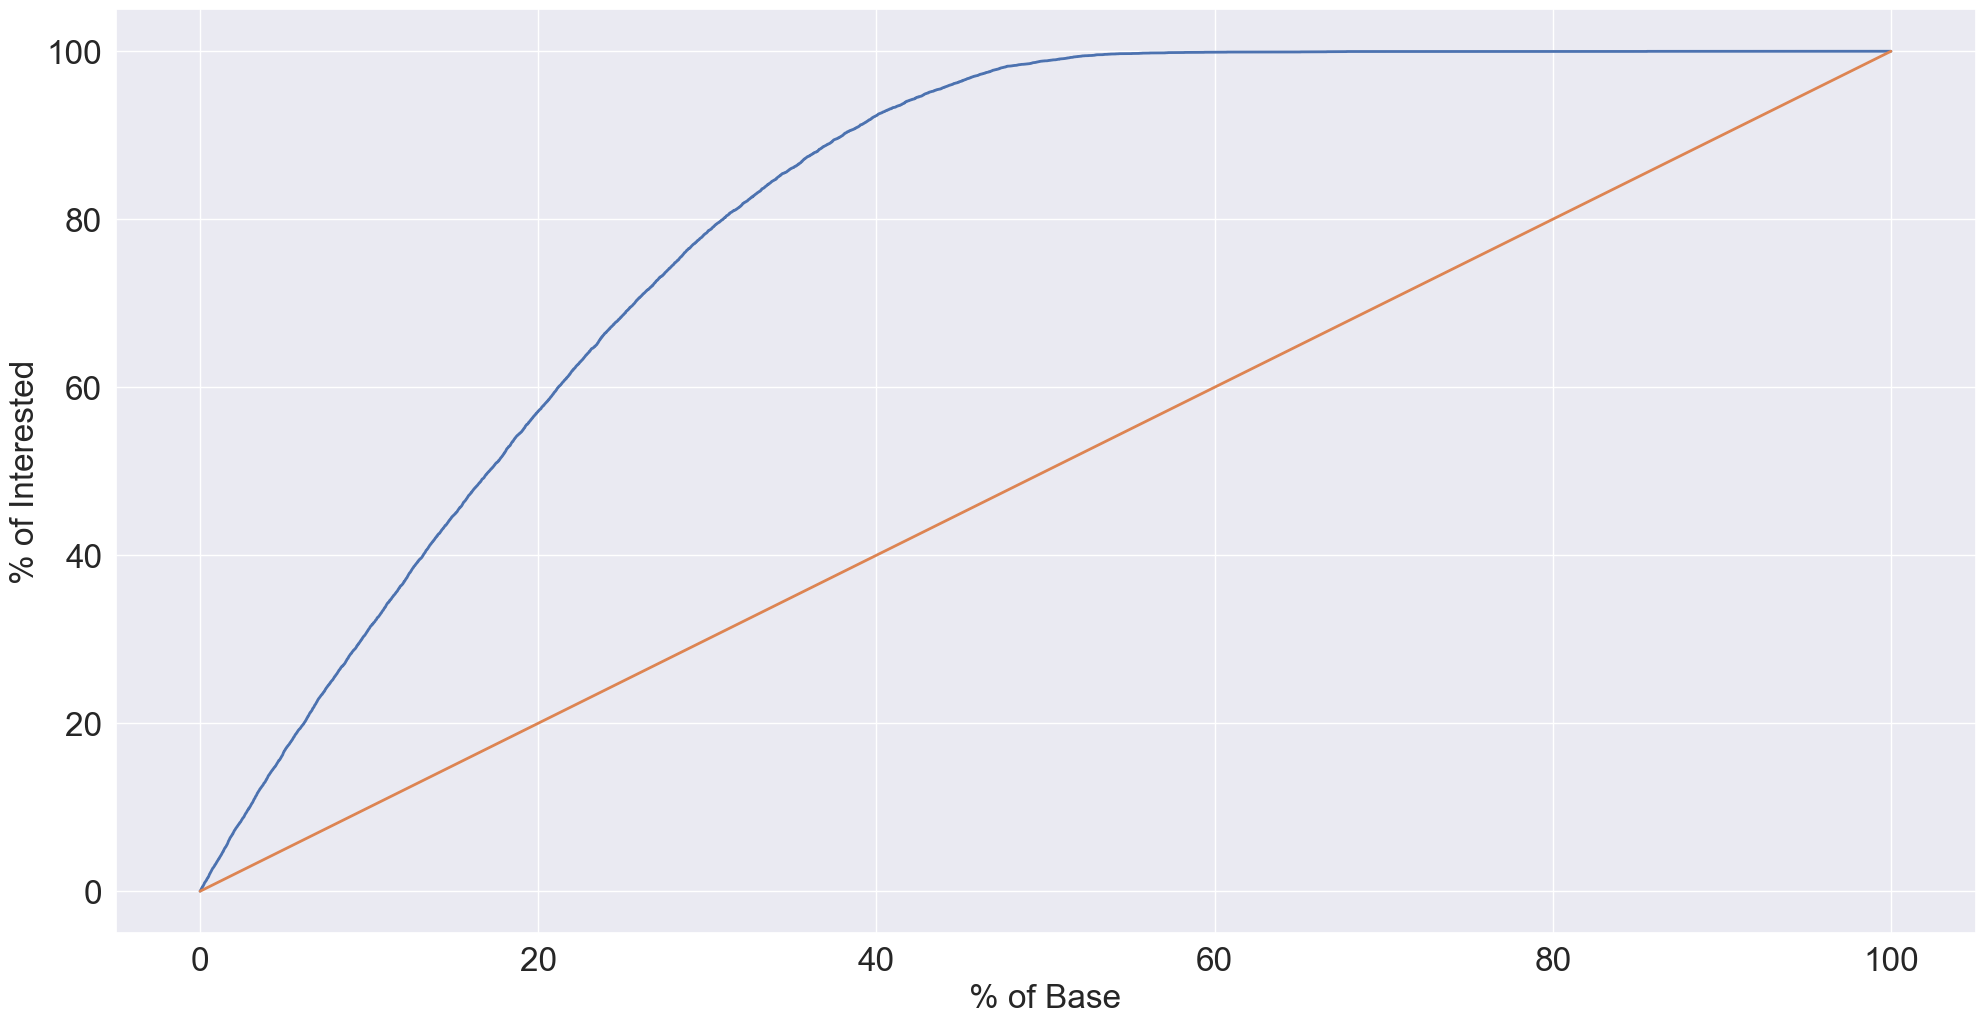

In [36]:
# curva ganho
ax = sns.lineplot(x = 'base_cum_perc', y = 'real_cum_perc', data = df_test, linewidth = 2)
ax = sns.lineplot(x = 'base_cum_perc', y = 'baseline', data = df_test, linewidth = 2)
ax.set_xlabel('% of Base', fontdict={'size': 24});
ax.set_ylabel('% of Interested', fontdict={'size': 24});
ax.set_yticklabels(ax.get_yticklabels(), size=24);
ax.set_xticklabels(ax.get_xticklabels(), size=24);
plt.show()

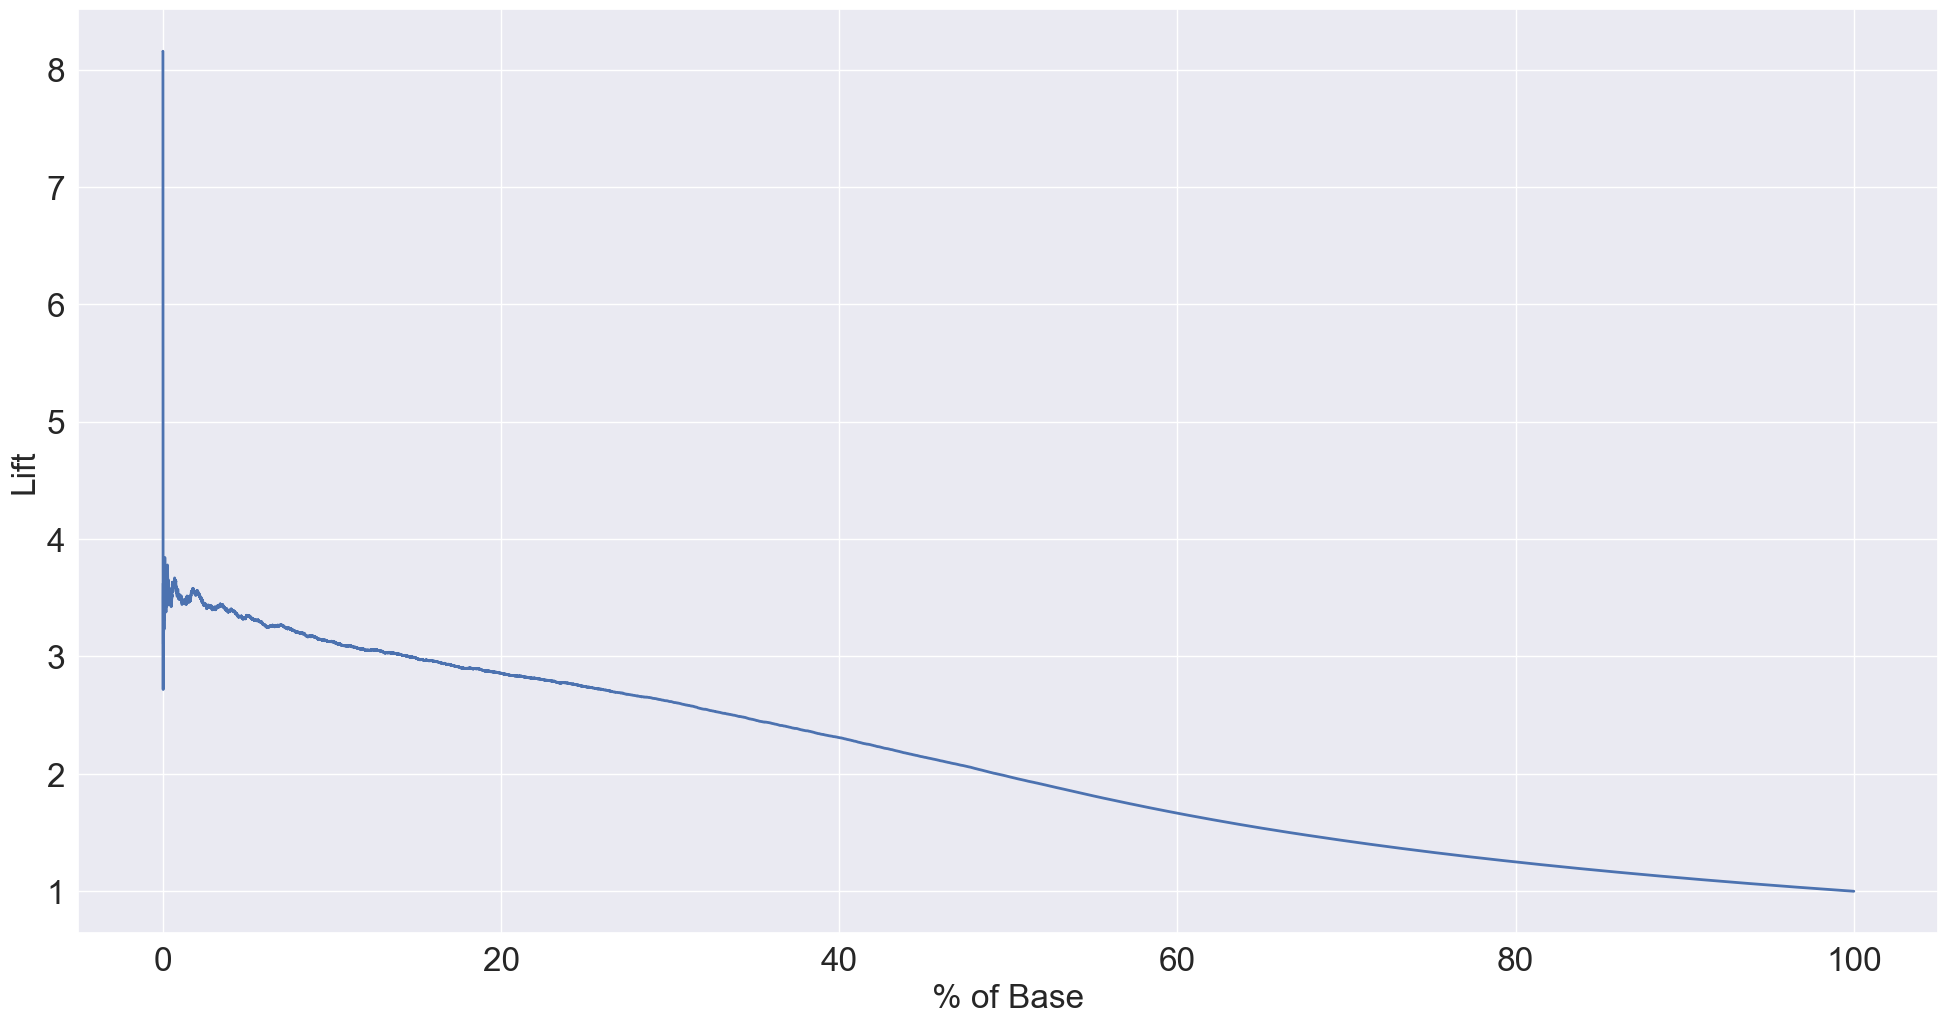

In [47]:
# curva lift
df_test['lift'] = df_test['real_cum_perc']/df_test['base_cum_perc']
ax = sns.lineplot(x = 'base_cum_perc', y = 'lift', data = df_test, linewidth = 2)
ax.set_xlabel('% of Base', fontdict={'size': 24});
ax.set_ylabel('Lift', fontdict={'size': 24});
ax.set_yticklabels(ax.get_yticklabels(), size=24);
ax.set_xticklabels(ax.get_xticklabels(), size=24);
plt.show()

## 8.2 Curva ROI

In [48]:
df_roi = df_test.copy()

# criando 10 buckets/bins para agrupar os clientes
df_roi['bucket'] = df_roi['score'].apply(lambda x: 0.9 if x >= 0.90 else 
                                                           0.8 if ( x >= 0.80) & ( x <= 0.90 ) else 
                                                           0.7 if ( x >= 0.70) & ( x <= 0.80 ) else 
                                                           0.6 if ( x >= 0.60) & ( x <= 0.70 ) else 
                                                           0.5 if ( x >= 0.50) & ( x <= 0.60 ) else 
                                                           0.4 if ( x >= 0.40) & ( x <= 0.50 ) else 
                                                           0.3 if ( x >= 0.30) & ( x <= 0.40 ) else 
                                                           0.2 if ( x >= 0.20) & ( x <= 0.30 ) else 
                                                           0.1 if ( x >= 0.10) & ( x <= 0.20 ) else 0.01)

# agrupando os clientes em buckets
df_roi = df_roi[['score', 'bucket']].groupby('bucket').agg({'min', 'count'}).reset_index()
df_roi.columns = df_roi.columns.droplevel() # remove o nível superior do cabeçalho (bucket e score), pois a função agg. cria mais um nível de cabeçalho
df_roi.columns = ['bucket', 'clients', 'min_score']
# df_roi.columns = ['bucket', 'min_score', 'clients'] # quando dropa o level as colunas clients e min_score ficam invertidas, por isso precisa reverter

In [49]:
gross_revenue_per_converted_client = 40 # simula uma receita bruta de 40 dólares por cliente convertido
client_cost = 4 # simula um custo de 4 dólares por cliente
# * Estes valores dependem muito da compreensão do negócio. Precisa ter uma noção de como é o CAC e de como é o LTV do negócio

# calcula a receita bruta e o custo
df_roi['bucket_gross_revenue'] = gross_revenue_per_converted_client * df_roi['clients'] * df_roi['min_score']
# neste cálculo, dando um exemplo para o bucket 0.1, considera-se que a cada 10 clientes 1 seja convertido, por isso ocorre a multiplicação pelo min_score
df_roi['bucket_cost'] = client_cost * df_roi['clients']

# # calcula qual o percentual da base alcançado após cada bucket alcançado
df_roi = df_roi.sort_values(by = 'bucket', ascending = False)
df_roi['base'] = df_roi['clients'].cumsum() / df_roi['clients'].sum()

# receita líquida do bucket
df_roi['bucket_revenue'] = df_roi['bucket_gross_revenue'] - df_roi['bucket_cost']

# receita líquida acumulada
df_roi['accumulated_revenue'] = df_roi['bucket_revenue'].cumsum()

df_roi

,bucket,clients,min_score,bucket_gross_revenue,bucket_cost,base,bucket_revenue,accumulated_revenue
9,0.90,4,0.901465,144.234371,16,0.000052,128.234371,128.234371
8,0.80,5381,0.800002,172192.400274,21524,0.070649,150668.400274,150796.634645
7,0.70,14332,0.700001,401296.334867,57328,0.258679,343968.334867,494764.969513
6,0.60,6658,0.600040,159802.594247,26632,0.346029,133170.594247,627935.563760
5,0.50,4264,0.500012,85281.982403,17056,0.401971,68225.982403,696161.546163
4,0.40,3567,0.400021,57075.011405,14268,0.448768,42807.011405,738968.557567
3,0.30,1860,0.300067,22325.011969,7440,0.473170,14885.011969,753853.569536
2,0.20,2055,0.200034,16442.811334,8220,0.500131,8222.811334,762076.380870
1,0.10,2887,0.100068,11555.834051,11548,0.538007,7.834051,762084.214921
0,0.01,35214,0.000020,28.281239,140856,1.000000,-140827.718761,621256.496160


<AxesSubplot: xlabel='base', ylabel='accumulated_revenue'>

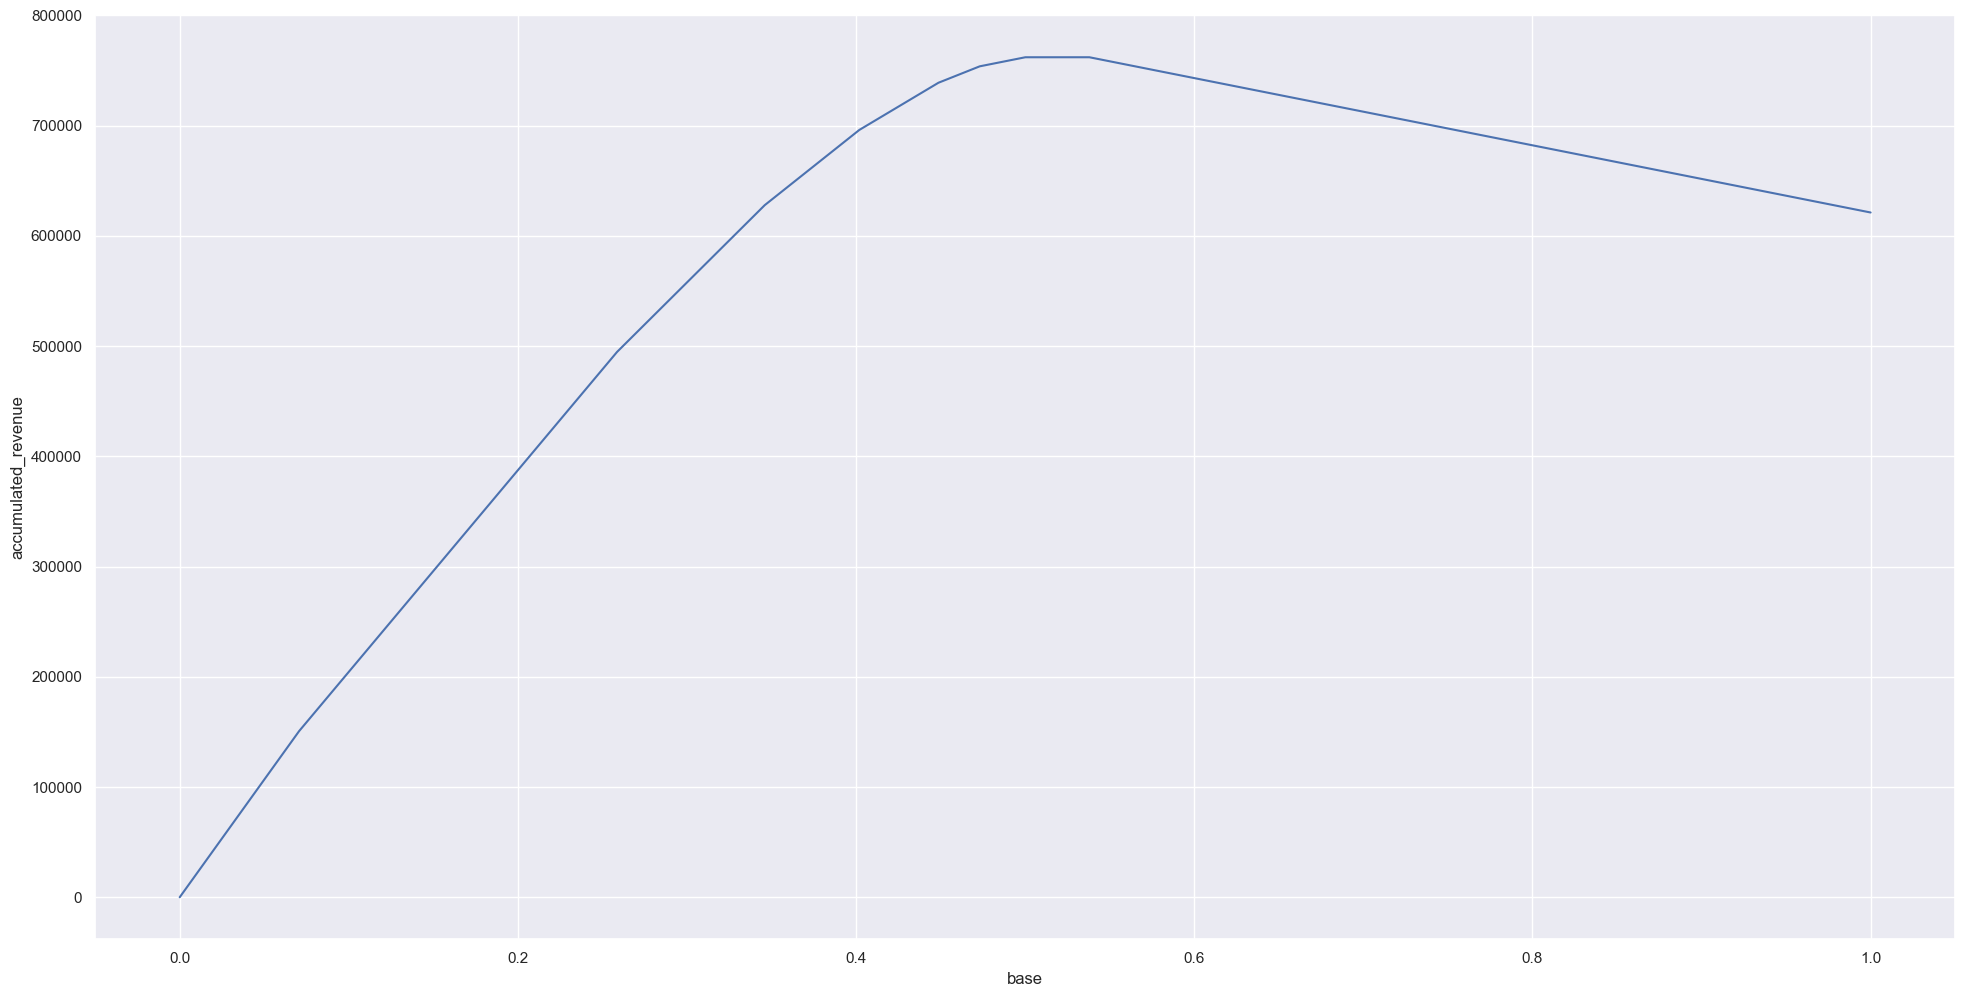

In [50]:
roi_curve = df_roi[df_roi['min_score'] >= 0.1]
sns.lineplot(x = 'base', y = 'accumulated_revenue', data = df_roi)

# 9.0 Modelo em produção

## 9.1 Armazenamento dos parâmetros e do modelo

In [41]:
# Parâmetros da preparação dos dados
pickle.dump(rc_encoder, open('parameter/region_code.pkl', 'wb'))
pickle.dump(psc_encoder, open('parameter/policy_sales_channel.pkl', 'wb'))

# Modelo final
pickle.dump(xgb_final, open('model/health_insurance_model.pkl', 'wb'))

## 9.2 Criação da classe HealthInsurance local

In [42]:
import pickle
import inflection
import numpy  as np
import pandas as pd

class HealthInsurance():
    
    def __init__(self):
        self.home_path = 'C:\\Users\\micro\\Desktop\\repos\\3_ciclo_intermediario\\7_health_insurance_cross_sell\\'
        self.region_code = pickle.load(open(self.home_path + 'parameter\\region_code.pkl', 'rb'))
        self.policy_sales_channel = pickle.load(open(self.home_path + 'parameter\\policy_sales_channel.pkl', 'rb'))
        
    def data_cleaning(self, df1):
        cols_old = ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage']
        
        # renomeando colunas
        snakecase = lambda x: inflection.underscore(x)
        cols_new = list(map(snakecase, cols_old))
        df1.columns = cols_new
        
        # alterando dados float64 para diminuir o tamanho do dataset
        df1['region_code'] = df1['region_code'].astype('int64')
        df1['policy_sales_channel'] = df1['policy_sales_channel'].astype('int64')
        df1['annual_premium'] = df1['annual_premium'].astype('float32')

        # transformando atributos categóricos em numéricos
        df1['gender'] = df1['gender'].apply(lambda x: 0 if x == 'Female' else 1)
        df1['vehicle_damage'] = df1['vehicle_damage'].apply(lambda x: 0 if x == 'No' else 1)
        df1['vehicle_age'] = df1['vehicle_age'].apply(lambda x: 1 if (x == '< 1 Year') else 
                                                      2 if (x == '1-2 Year') else 
                                                      3 if (x == '> 2 Years') else x)
        
        return df1
        
    def data_preparation(self, df2):
        df2['annual_premium'] = (df2['annual_premium'] - df2['annual_premium'].mean()) / df2['annual_premium'].std()
        df2['age'] = (df2['age'] - df2['age'].min()) / (df2['age'].max() - df2['age'].min())
        df2['vintage'] = (df2['vintage'] - df2['vintage'].min()) / (df2['vintage'].max() - df2['vintage'].min())
        df2.loc[:,'region_code'] = df2['region_code'].map(self.region_code)
        df2.loc[:,'policy_sales_channel'] = df2['policy_sales_channel'].map(self.policy_sales_channel)
        # para caso algum 'policy_sales_channel' ou 'region_code' não aparça na validação, preencher com 0
        df2 = df2.fillna(0)
        cols_selected_mdi = ['vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage', 'policy_sales_channel', 'previously_insured']
        df2 = df2[cols_selected_mdi]
        
        return df2

    def get_prediction(self, xgb_final, df_original, df_prep):
        predicao = xgb_final.predict_proba(df_prep)
        df_original['score'] = predicao[:,1].tolist()
        
        return df_original.to_json(orient='records')

## 9.3 Criação da API local

In [43]:
# import pickle
# import os
# import pandas as pd
# import numpy  as np
# from flask import Flask, request, Response

# path = 'C:\\Users\\micro\\Desktop\\repos\\3_ciclo_intermediario\\7_health_insurance_cross_sell\\'
# model = pickle.load(open(path + 'model\\health_insurance_model.pkl', 'rb'))

# app = Flask(__name__)

# @app.route('/healthinsurance/predict', methods=['POST'])
# def health_insurance_predict():
#     test_json = request.get_json()

#     if test_json:
#         if isinstance(test_json, dict):
#             test_raw = pd.DataFrame(test_json, index=[0])

#         else:
#             test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())

#         pipeline = HealthInsurance()

#         df1 = pipeline.data_cleaning(test_raw)

#         df2 = pipeline.data_preparation(df1)

#         df_response = pipeline.get_prediction(model, test_raw, df2)

#         return df_response

#     else:
#         return Response('{}', status=200, mimetype='application/json')

# if __name__ == '__main__':
#     app.run('127.0.0.1')
#     # port = os.environ.get('PORT', 5000)
#     # app.run(host = '0.0.0.0', port = port, debug = True)

## 9.4 Teste da API local

In [44]:
import pickle
import inflection
# import os
import math
import datetime
import pandas as pd
import numpy  as np
from flask import Flask, request, Response
import requests

d1 = pd.read_csv('\\Users\\micro\\Desktop\\repos\\3_ciclo_intermediario\\7_health_insurance_cross_sell\\data\\test.csv')

# converte o dataframe em json para fazer a comunicação entre os sistemas
data = json.dumps(d1.to_dict(orient = 'records'))

In [45]:
# chamada em API
url = 'http://127.0.0.1:5000/healthinsurance/predict'
# url = 'https://health-insurance-api-5z78.onrender.com/healthinsurance/predict'
header = {'Content-type': 'application/json'} 
data = data

In [46]:
r = requests.post(url, data = data, headers = header) # post: precisa enviar algum dado para requerir
print('Status Code {}'.format(r.status_code)) # para ver se a requisição é válida ou não 

ConnectionError: HTTPConnectionPool(host='127.0.0.1', port=5000): Max retries exceeded with url: /healthinsurance/predict (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x0000016AAC163AF0>: Failed to establish a new connection: [WinError 10061] Nenhuma conexão pôde ser feita porque a máquina de destino as recusou ativamente'))

In [ ]:
# pega o json da requisição e converte em dataframe
d2 = pd.DataFrame(r.json(), columns = r.json()[0].keys())

# ordenando a base de acordo com a propensão de compra de cada cliente
d2.sort_values('score', ascending = False).head()

In [ ]:
# gerando um csv com as predições
d2.to_csv('predictions.csv', index = False) 